# This notebook will analyze the images taken by the automated FRD setup
- make sure you have all your images taken by the set up saved in results/

In [ ]:
# Imports
import os
import sys
import zwoasi as asi

from IPython.display import clear_output, Image, display
import ipywidgets
import cv2
import time
import numpy as np
import warnings
from astropy.modeling.models import Gaussian2D, AiryDisk2D
from astropy.modeling import fitting
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
from astropy.time import Time
from astropy.visualization import simple_norm
from astropy.nddata import block_reduce

from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, ApertureStats
from photutils.centroids import centroid_quadratic, centroid_com, centroid_1dg, centroid_2dg
from photutils.profiles import RadialProfile
from PIL import Image, ImageFont, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
from pathlib import Path


# FRD Fitting:

In [ ]:
# Take input file from command-line arguments
input_file = sys.argv[1]  # The FITS file passed from Snakemake
output_dir = os.path.join(os.getcwd(), 'results')


In [ ]:
'''
# Define the paths for data and results directories relative to the current working directory (root)
data_path = os.path.join(os.getcwd(), 'data', 'Aper-00-d00_20241003_191651.fits')  # ./data/throughput.txt
results_dir = os.path.join(os.getcwd(), 'results')  # ./results/

# Load the throughput data
data = pd.read_csv(data_path, delim_whitespace=True, header=None, names=["Wavelength", "Throughput"])
'''

0 C:\Users\CFBLAB1\Desktop\LFAST-FRD\2024-10-03-lfast-18um-0027-2\Aper-00-d00_20241003_191651.fits
background level from annulus: 620.126845203242
[288.6215773  216.33702829]
Radius: (133.48135804164704, 1067.851)
 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1   294.0   217.0 223927551.16633677


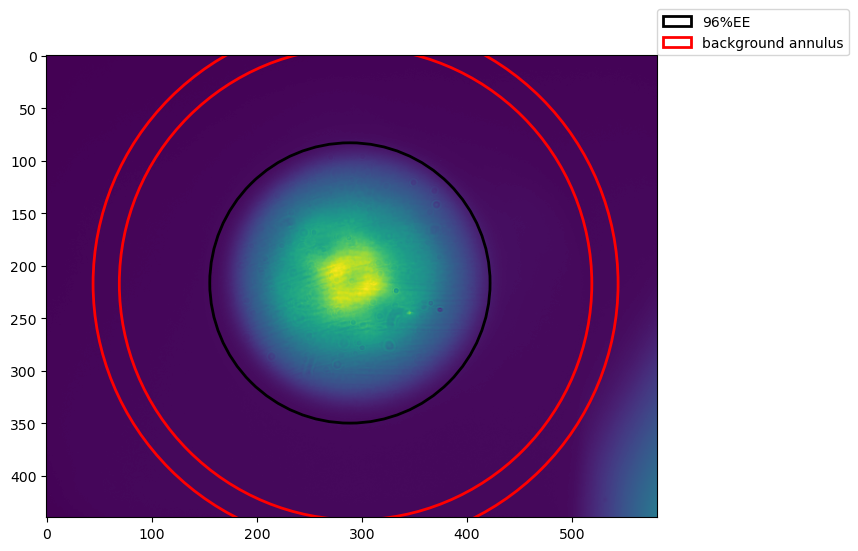

1 C:\Users\CFBLAB1\Desktop\LFAST-FRD\2024-10-03-lfast-18um-0027-2\Aper-00-d04_20241003_191741.fits
background level from annulus: 654.9748836635952
[294.4221371  221.03106719]
Radius: (167.1336546298028, 1337.069)
 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1   294.0   217.0 228183737.69472197


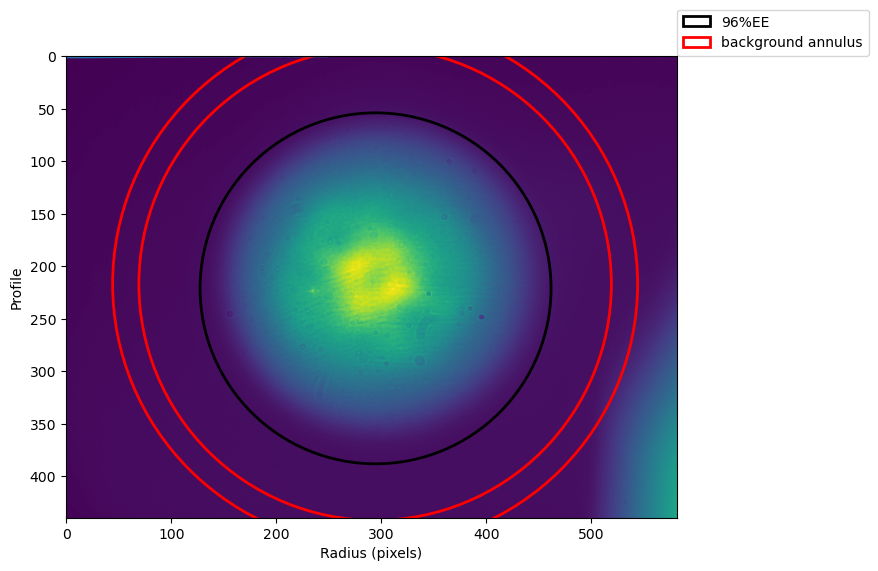

2 C:\Users\CFBLAB1\Desktop\LFAST-FRD\2024-10-03-lfast-18um-0027-2\Aper-00-d08_20241003_191833.fits
background level from annulus: 645.0821905143455
[nan nan]


ValueError: 'positions' must not contain any non-finite (e.g., NaN or inf) positions

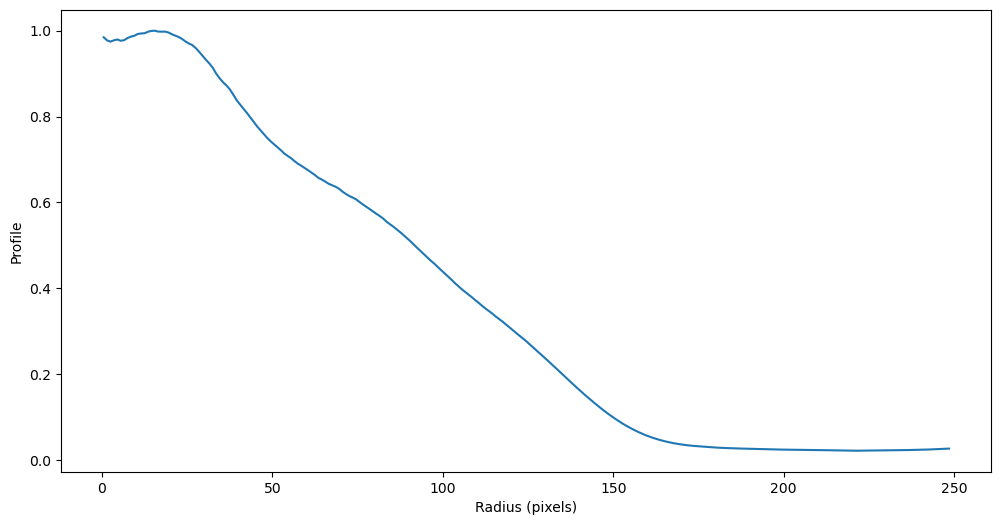

In [39]:
# Load the single image
print(f"Analyzing file: {input_file}")
with fits.open(input_file) as fits_data:
    img = fits_data[0].data

    img = fits_data[0].data
    imghdr = fits_data[0].header
    #reduction_factor = 4
    reduction_factor = 8
    #reduction_factor = 16
    img2 = block_reduce(img,reduction_factor, func=np.mean)

    #print(img)

    if (True):
        #print(f"Aperture photometry curve of growth...")
        #(xcenter, ycenter) = (556, 432)
        (xcenter, ycenter) = (294, 217)

        # determine the mean background pixel level
        annulus_aperture = CircularAnnulus([xcenter,ycenter], r_in=int((2000-200)/reduction_factor), r_out=int(2000/reduction_factor))
        aperstats = ApertureStats(img, annulus_aperture)
        bkg = aperstats.mode
        print(f'background level from annulus: {bkg}')

        EEEnc = 96  # desired encircled energy for determining light radius 
        
        # subtract background
        img3 = img2-bkg
        #img4 = np.clip(img3,0,400)

        # find centroid
        xycen =  (xcenter, ycenter)
        if (True):
            #xycen = centroid_com(img3)
            xycen = centroid_quadratic(img3, xpeak=xcenter, ypeak=ycenter, fit_boxsize=51, search_boxsize=21)
            #if (not xycen[0] > 0):
            #    print(f'trying com to find centroid')
            #    xycen = centroid_com(img3)
            #    if (not xycen[0] > 0 ):
            #        print(f'somethinng wrong, cant find centroid')

 
        print(f'{xycen}')
        edge_radii = np.arange(2000/reduction_factor)
        rp = RadialProfile(img3, xycen, edge_radii, error=None, mask=None)
        rp.normalize()
        ree = np.interp((100-EEEnc)/100, rp.profile[::-1], rp.radius[::-1])
        ree2 = np.round(reduction_factor*ree,3)
        print(f'Radius: {ree, ree2}')
        # flux in circular aperture
        frad = CircularAperture([xcenter,ycenter], r=ree )
        phot_table = aperture_photometry(img3, frad)
        print(phot_table)
        flux = int(phot_table['aperture_sum'][0])

        fits.setval(file,'radiusp',value=ree2 ,comment=" pixel radius at "+str(EEEnc)+" percent EE")
        fits.setval(file,'psize',value=pixelsize ,comment="size of pixel in microns") 
        fits.setval(file,'radiusmm',value=ree2*pixelsize/1000 ,comment=" mm radius at "+str(EEEnc)+" percent EE") 
        fits.setval(file,'flux',value=flux ,comment=" Flux within "+str(EEEnc)+" percent EE")

    if (False):
        print(f"fitting TrapezoidDisk2D...")
        p_init = models.TrapezoidDisk2D(np.max(img2)-np.min(img2),xycen[1],xycen[0],ree,5)
        fit_p = fitting.LevMarLSQFitter()
        #yi,xi = np.indices(img)
        yi,xi = np.mgrid[:img2.shape[0], :img2.shape[1]]
        p = fit_p(p_init, yi, xi, img2)
        print(f"{p.amplitude.value},{p.y_0.value},{p.x_0.value},  {p.R_0.value},  {p.slope.value}\n\n")

        
    if ( True ):
        plot_apertures = CircularAperture([xycen[0], xycen[1]], r=ree)
        #for platting purposes
        #ap_patches = apertures[0].plot(color='black', lw=2, label='80%EE')
        ap_patches = plot_apertures.plot(color='black', lw=2, label=str(EEEnc)+'%EE')
        ann_patches = annulus_aperture.plot(color='red', lw=2, label='background annulus')
        handles = (ap_patches[0], ann_patches[0])

        plt.imshow(img3)
        plt.legend(loc=(1,1), handles=handles)
        plt.show()        
        rp.plot()


In [32]:
not xycen[0] > 0

True

In [33]:
# for each aperture plot the radius versus stage distance.  The slope should be the output f-ratio
plt.rcParams['figure.figsize'] = [12,6]

mini = min(fratios)
maxi =max(fratios)
scale = (fratios-mini)/(maxi-mini)
colors = cm.rainbow(scale)

tmpx = np.linspace(-20, 25, 26)#np.arange(0,26)#(40,100)


fout = []
oflux = []
ofluxf = []
for i,aperture in enumerate(apertures):
#for i,aperture in enumerate(apertures[0:-1]):
    #if i == len(apertures) - 9:  # Skip the 9th aperture from the end
        #continue
    #if i > 0 : continue
    #print(i,aperture)
    ffiles = list( sorted( datapath.glob("Aper-"+"%02d"%i+"*.fits" ) ) )
    radius = []
    distance = []
    aflux = []
    
    for file in ffiles:
        #print(file)
        radius.append(2*fits.getval(file,'radiusmm'))
        distance.append(fits.getval(file,'distance'))
        aflux.append(fits.getval(file,'flux'))
        
    #print(radius, distance)
    plt.subplot(1,2,1)
    plt.plot(distance,radius,'o-',label='f/'+str(fratios[i])+'  '+ str(np.round(apertures[i],2))+'mm', c=colors[i])
    plt.subplot(1,2,2)
    dflux = aflux / aperture**2
    plt.plot(distance,dflux,'o-',label='f/'+str(fratios[i])+'  '+ str(np.round(apertures[i],2))+'mm', c=colors[i])
             

    if i < 0 :
        slope, intercept = np.polyfit(distance, radius, deg=1)
    else:
        slope, intercept = np.polyfit(distance, radius, deg=1)
    #print(slope, intercept)
    tmpy = intercept + slope*tmpx
    plt.subplot(1,2,1)
    plt.plot(tmpx,tmpy,'-',c=colors[i])
    fout.append(1/slope)
    oflux.append(dflux[0])
    ofluxf.append(dflux[-1])

plt.subplot(1,2,1)
plt.plot([0,26],[maxheight*pixelsize/1000,maxheight*pixelsize/1000 ],'-k',label='detector height')
#plt.xlim(90,10)
plt.xlim(-15,45)
plt.ylim(0, 16)
plt.legend()
plt.title("Output Beam Diameter vs Stage Distance")
plt.xlabel("Stage Distance [mm]")
plt.ylabel("Output Beam Diameter [mm]")
#plt.figure(figsize=(6,10))

plt.subplot(1,2,2)
#plt.xlim(75,48)
#plt.xlim(-2,40)
plt.xlabel("Stage Distance [mm]")
plt.ylabel("Aperture Flux Density [cnts/mm^2]")
#plt.ylabel("Relative Aperture Flux Density")
#plt.figure(figsize=(10,6))

plt.tight_layout()

setup = '-Nikon 20mm objective\n-Alphabright source\n-50um Thorlabs Cable'
name= "output_beam_and_flux_density.png"
fig_save_path = os.path.join(dirpath, name)
plt.savefig(fig_save_path)

KeyError: "Keyword 'RADIUSMM' not found."

In [18]:
#apertures
tmpx

array([-20. , -18.2, -16.4, -14.6, -12.8, -11. ,  -9.2,  -7.4,  -5.6,
        -3.8,  -2. ,  -0.2,   1.6,   3.4,   5.2,   7. ,   8.8,  10.6,
        12.4,  14.2,  16. ,  17.8,  19.6,  21.4,  23.2,  25. ])

In [19]:
fratios
fout

[2.2814059483553577,
 2.2893019751158836,
 2.4242531791110733,
 2.73030117733863,
 3.086930525757672,
 3.4210671711144225,
 3.729165617838839,
 4.016362500171197,
 4.057515772983942,
 4.312487315896682,
 4.681691776140229,
 4.9165784468607345]

In [20]:
print(fratios)
print(fout)

[1.7 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  7.  8. ]
[2.2814059483553577, 2.2893019751158836, 2.4242531791110733, 2.73030117733863, 3.086930525757672, 3.4210671711144225, 3.729165617838839, 4.016362500171197, 4.057515772983942, 4.312487315896682, 4.681691776140229, 4.9165784468607345]


In [21]:

txt_file_path = os.path.join(datapath, 'fratios.txt')

with open(txt_file_path, "w") as file:
    file.write("Array 1:\n")
    np.savetxt(file, fratios, fmt='%d')  
    file.write("\nArray 2:\n")
    np.savetxt(file, fout, fmt='%d') 


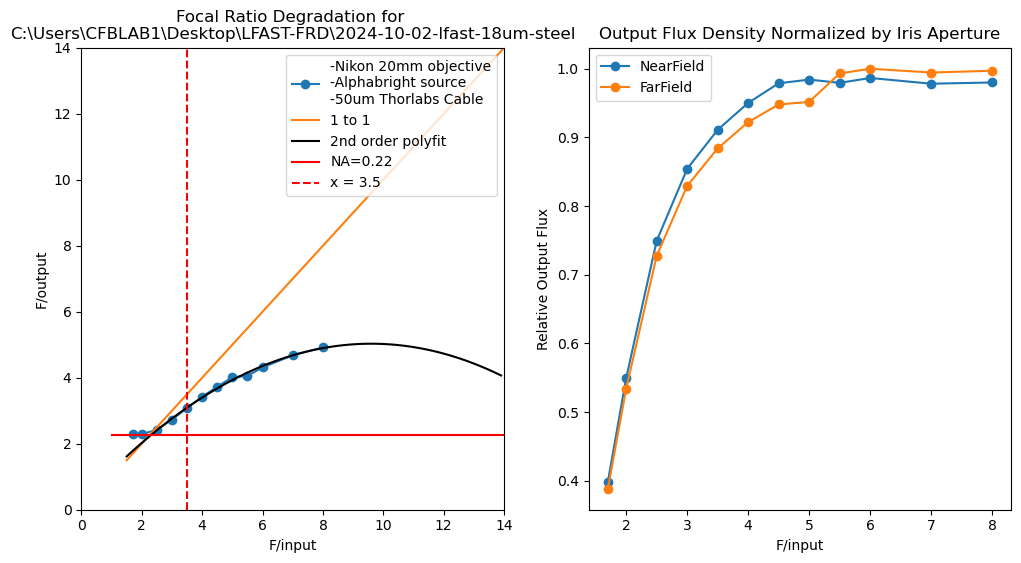

In [22]:
#sqr, slope, intercept = np.polyfit(fratios[3:-1], fout[3:], deg=2)
sqr, slope, intercept = np.polyfit(fratios[3:], fout[3:], deg=2)
fx = np.arange(1.5,14,0.1) #input f
fy = intercept + slope*fx + sqr*(fx)**2 # output f

plt.subplot(1,2,1)

#plt.plot(fratios[0:-1],fout, 'o-', label=setup)
plt.plot(fratios,fout, 'o-', label=setup)
plt.plot([1.5,14],[1.5,14], '-', label='1 to 1')
plt.ylim(0, 14)
plt.xlim(0, 14)
plt.plot(fx,fy,'-k',label='2nd order polyfit')
na = 0.22
plt.plot([1,14],[1/(2*na),1/(2*na)],'-r',label="NA="+str(na))
plt.axvline(x=3.5, color='r', linestyle='--', label='x = 3.5')
plt.legend()
plt.title("Focal Ratio Degradation for \n"+str(datapath))
plt.xlabel("F/input")
plt.ylabel("F/output")

noflux = oflux/max(ofluxf)
nofluxf = ofluxf/max(ofluxf)

plt.subplot(1,2,2)
#plt.plot(fratios[0:-1],noflux, 'o-', label=setup)
plt.plot(fratios,noflux, 'o-', label='NearField')
plt.plot(fratios,nofluxf, 'o-', label='FarField')
plt.legend()
plt.xlabel("F/input")
plt.ylabel("Relative Output Flux")
plt.title("Output Flux Density Normalized by Iris Aperture")


# Save plot to results directory
plot_name = Path(input_file).stem + "_analysis.png"
plot_path = os.path.join(output_dir, plot_name)
plt.savefig(plot_path)
print(f"Saved plot to {plot_path}")

In [ ]:
image_file='C:/Users/CFBLAB1/Desktop/LFAST-FRD/2024-09-11-50um/Aper-00-d00_20240912_052055.fits'
fits.info(image_file)
image_data = fits.getdata(image_file, ext=0)
print("Dimensions of the 2D array:", image_data.shape)
# display image
plt.figure(figsize=(4, 3))
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.title(image_file)
#plt.savefig(f"{image_file}.png", dpi=300) #('Filter2-d1-30ms_00001.png', dpi=300)
plt.show()